# Insider Threat

# Long-range Forecasting and Pattern Discovery given Limited Data

In [99]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
# import theano
# import theano.tensor as tt
# import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
from beakerx import *
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 20, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")
import gpflow
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from gpflowopt.domain import ContinuousParameter
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.acquisition import ExpectedImprovement
from gpflowopt.optim import SciPyOptimizer
from gpflowopt.optim import StagedOptimizer
from gpflowopt.optim import MCOptimizer

In [2]:
import rpy2
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [2]:
email_filtered = pd.read_csv("../../data/email_filtered.csv", parse_dates=["date"])

In [3]:
email_filtered.head()      

In [4]:
email_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11920 entries, 0 to 11919
Data columns (total 12 columns):
id             11920 non-null object
date           11920 non-null datetime64[ns]
user           11920 non-null object
pc             11920 non-null object
to             11920 non-null object
cc             6101 non-null object
bcc            593 non-null object
from           11920 non-null object
activity       11920 non-null object
size           11920 non-null int64
attachments    3809 non-null object
content        11920 non-null object
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 1.1+ MB


Let's select one user in particular who is a known insider.


In [7]:
# The insider
df_insider = email_filtered[email_filtered["user"] == "CDE1846"]
df_insider.head()
df_insider.shape

(3165, 12)

In [120]:
emails_per_month = df_insider.resample(rule = "1M", on = "date").sum().reset_index()
emails_per_month["date"] = pd.to_datetime(emails_per_month["date"], format = "%Y-%m-%d")
emails_per_month.columns = ["ds", "y"]
emails_per_month

In [121]:
emails_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
ds    17 non-null datetime64[ns]
y     17 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 352.0 bytes


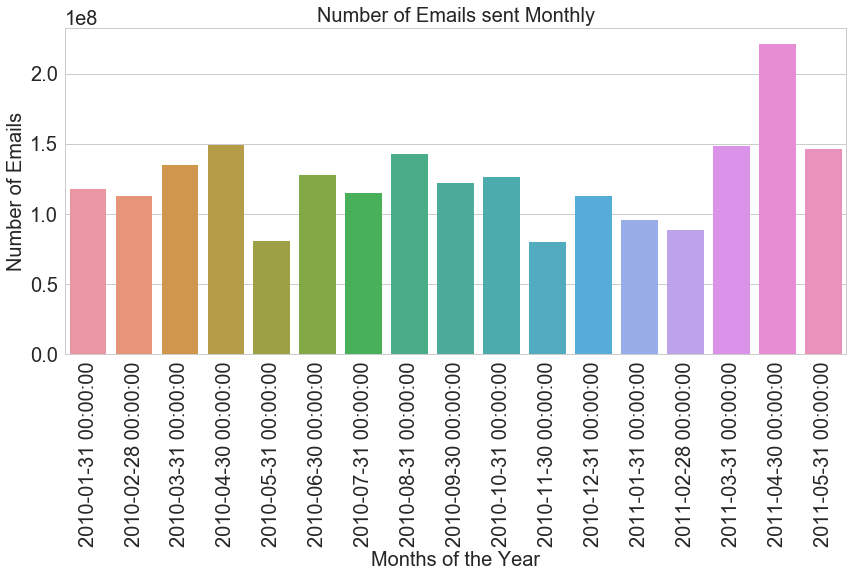

In [129]:
fig, ax = plt.subplots()
sns.barplot(data = emails_per_month, x = "ds", y = "y")
ax.set_xticklabels(labels = emails_per_month["ds"], rotation = 90)
ax.set_xlabel("Months of the Year")
ax.set_ylabel("Number of Emails")
ax.set_title("Number of Emails sent Monthly");

In [40]:
df_insider_non_org = df_insider[~df_insider['to'].str.contains('dtaa.com')]
df_insider_non_org

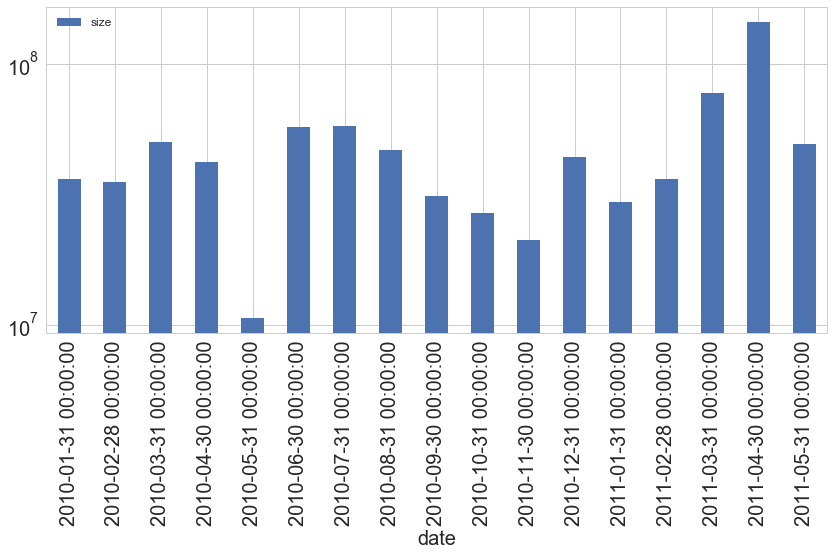

In [42]:
df_insider_non_org.resample(rule = "1M", on = "date").sum().plot(kind = "bar", logy = "size");

Explore Insider Threat Case

In [88]:
# Here, we look at the case where the insider email IP to their home account
# The data is resampled per month and the anomalous behavior is clearly
# visible
df_insider_ewing = df_insider_non_org[df_insider_non_org['to'] == 'Ewing_Carlos@comcast.net']
df = df_insider_ewing.resample('1M', on='date').sum().reset_index()
df.columns = ["ds", "y"]

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
ds    17 non-null datetime64[ns]
y     17 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 352.0 bytes


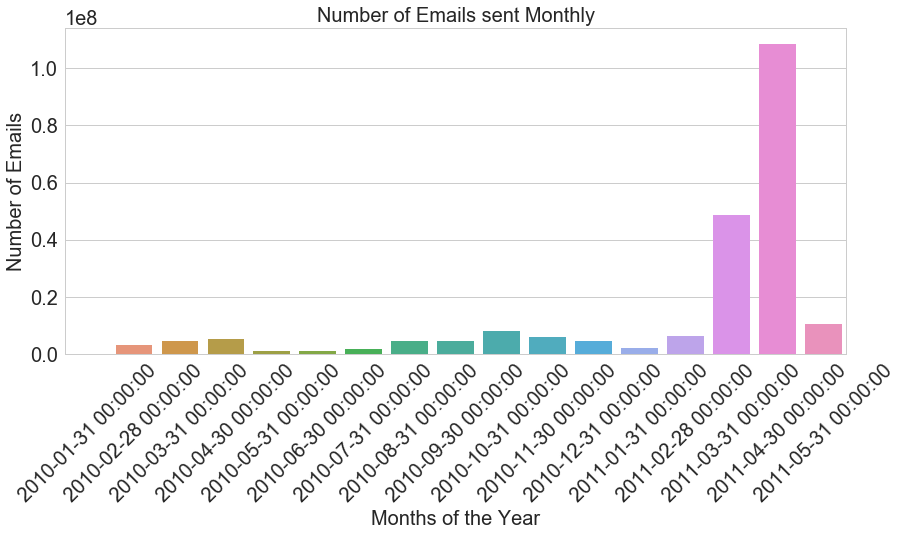

In [132]:
fig, ax = plt.subplots()
sns.barplot(data = df, x = "ds", y = "y")
ax.set_xticklabels(labels = df.ds, rotation = 45)
ax.set_xlabel("Months of the Year")
ax.set_ylabel("Number of Emails")
ax.set_title("Number of Emails sent Monthly");

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
ds    17 non-null datetime64[ns]
y     17 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 352.0 bytes


In [133]:
X_complete = np.array([df.index]).reshape((17, 1)).astype('float64')
X_train = X_complete[0:13, ]
X_test = X_complete[17:17, ]
Y_complete = np.array([df.y]).reshape((17, 1)).astype('float64')
Y_train = Y_complete[0:13, ]
Y_test = Y_complete[17:17, ]
D = Y_train.shape[1];

In [134]:
D

1

In [135]:
Y_train.shape; X_train.shape; Y_test.shape; X_test.shape; X_complete.shape

(13, 1)

(13, 1)

(0, 1)

(0, 1)

(17, 1)

In [136]:
Y_train[0:3, ]; X_train[0:3, ]; X_test[0:3, ]; X_complete[0:3, ]

array([[  181588.],
       [ 3250489.],
       [ 4749784.]])

array([[ 0.],
       [ 1.],
       [ 2.]])

array([], shape=(0, 1), dtype=float64)

array([[ 0.],
       [ 1.],
       [ 2.]])

In [57]:
Y_train.dtype

dtype('float64')

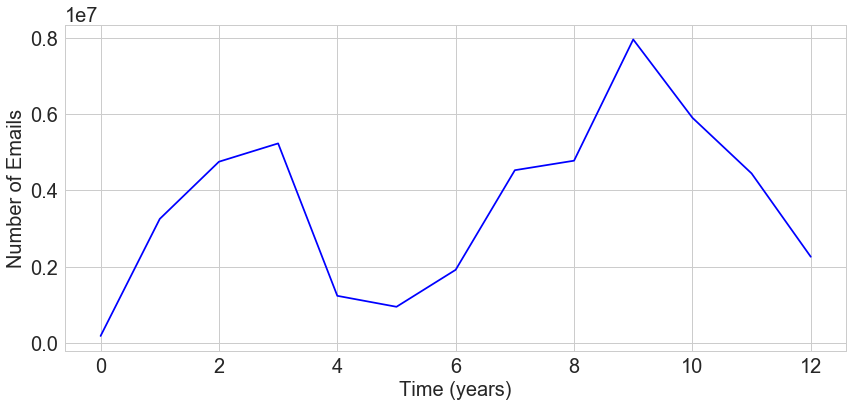

In [137]:
fig, ax = plt.subplots()
ax.plot(X_train.flatten(),Y_train.flatten(), c ='b')
# ax.set_xticklabels([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010])
ax.set_xlabel('Time (years)')
ax.set_ylabel('Number of Emails');
# fig1 = plt.gcf()
# py.offline.iplot_mpl(fig1);

## Gaussian Process modeling

This study used a Gaussian Process model with a Spectral Mixture (SM) kernel proposed by Wilson (2014). This is because the SM kernel is capable of capturing hidden structure with data without hard cording features in a kernel. Moreover, the SM kernel is capable of performing long-range extrapolation beyond available data.


/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:112: RuntimeWarning:

divide by zero encountered in log



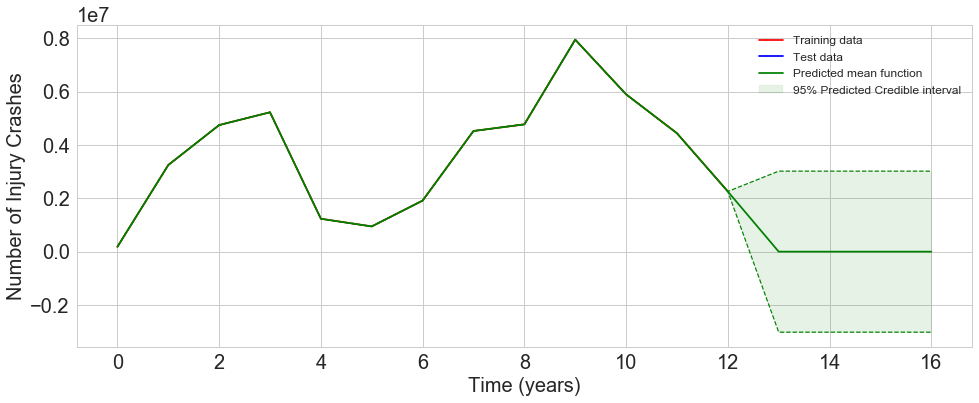

In [138]:
Q = 10 # nr of terms in the sum
max_iters = 1000

# Trains a model with a spectral mixture kernel, given an ndarray of 
# 2Q frequencies and lengthscales
def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]

    kterms = []
    for i in range(Q):
        rbf = gpflow.kernels.RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = gpflow.transforms.Exp()
        cos = gpflow.kernels.Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)

    k = np.sum(kterms) + gpflow.kernels.Linear(D) + gpflow.kernels.Bias(D)
    m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
    return m

In [ ]:
m.optimize(maxiter=max_iters)

In [ ]:
def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     ax.set_xticklabels([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020])
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Number of Injury Crashes');
    ax.plot(X_train.flatten(),Y_train.flatten(), c='r', label = 'Training data')
    ax.plot(X_test.flatten(),Y_test.flatten(), c='b', label = 'Test data')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g', label = "Predicted mean function")
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1, label = "95% Predicted Credible interval")
    plt.legend(loc = "best")
    plt.tight_layout()

In [ ]:
plotprediction(m);

In [139]:
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

Name,Type,Values
freq0,Continuous,[ 0. 5.]
freq1,Continuous,[ 0. 5.]
freq2,Continuous,[ 0. 5.]
freq3,Continuous,[ 0. 5.]
freq4,Continuous,[ 0. 5.]
freq5,Continuous,[ 0. 5.]
freq6,Continuous,[ 0. 5.]
freq7,Continuous,[ 0. 5.]
freq8,Continuous,[ 0. 5.]
freq9,Continuous,[ 0. 5.]


In [140]:
from gpflowopt.design import LatinHyperCube
from gpflowopt.acquisition import ExpectedImprovement
from gpflowopt import optim, BayesianOptimizer
design = LatinHyperCube(6, domain)
X = design.generate()
Y = objectivefx(X)

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:112: RuntimeWarning:

divide by zero encountered in log



/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:109: RuntimeWarning:

overflow encountered in exp



In [141]:
m = gpflow.gpr.GPR(X, Y, kern=gpflow.kernels.Matern52(domain.size, ARD=False))

In [142]:
ei = ExpectedImprovement(m)

In [143]:
opt = optim.StagedOptimizer([optim.MCOptimizer(domain, 5000), optim.SciPyOptimizer(domain)])

In [144]:
optimizer = BayesianOptimizer(domain, ei, optimizer=opt)

In [145]:
with optimizer.silent():
    result = optimizer.optimize(objectivefx, n_iter=24)

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:109: RuntimeWarning:

overflow encountered in exp

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:112: RuntimeWarning:

divide by zero encountered in log

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:181: RuntimeWarning:

invalid value encountered in maximum



In [146]:
m = create_model(result.x[0,:])
m.optimize()

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:109: RuntimeWarning:

overflow encountered in exp



      fun: 228.76567608528563
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.50601136e-011,  -1.19043554e-009,  -5.32154101e-011,
        -7.04911040e-006,   0.00000000e+000,  -4.51059482e-006,
        -3.27138975e-014,  -6.15992159e-006,  -7.55307361e-077,
        -3.95497583e-006,  -7.24388675e-009,  -7.11867233e-006,
        -0.00000000e+000,  -4.55577855e-006,  -2.96090628e-002,
        -6.57125686e-006,   0.00000000e+000,  -4.20776233e-006,
        -3.15048331e+000,   2.79521940e-007,   0.00000000e+000,
         1.98748359e-007,  -0.00000000e+000,  -6.81243549e-006,
        -0.00000000e+000,  -4.46293519e-006,  -0.00000000e+000,
        -1.48643034e-006,  -0.00000000e+000,  -9.63777944e-007,
         2.50941716e+006,  -8.85057949e-006,  -0.00000000e+000,
        -5.66364512e-006,  -3.88354633e-001,  -3.79940209e-006,
         1.72607297e-141,  -2.43516076e-006,  -0.00000000e+000,
        -1.46666268e-006,  -0.00000000e+000,  -9.51306869e-007,
     

/Users/demaasit/anaconda3/lib/python3.6/site-packages/gpflow/transforms.py:112: RuntimeWarning:

divide by zero encountered in log



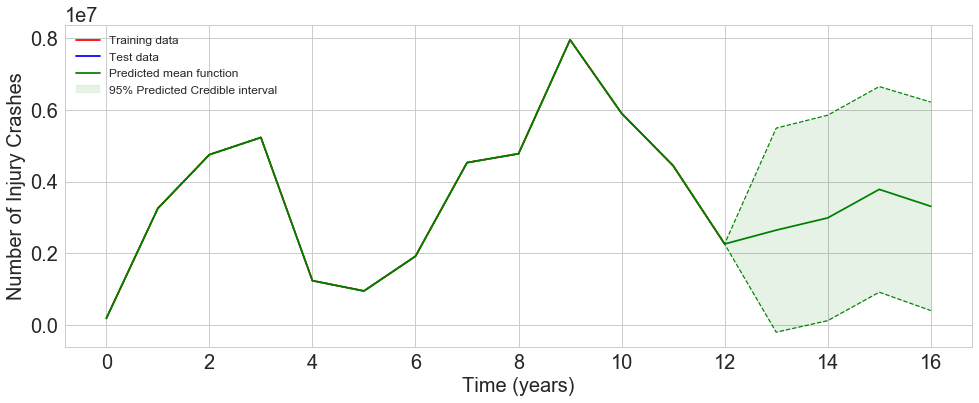

In [147]:
plotprediction(m)

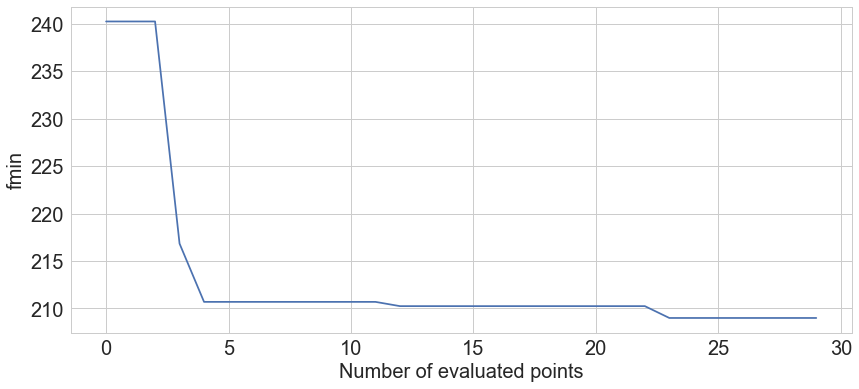

In [148]:
f, axes = plt.subplots()
f = ei.data[1][:,0]
axes.plot(np.arange(0, ei.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points');

In [149]:
# # save the model and results to the files 'model.pkl' and 'results.pkl' for later use
# with open('model_optimized.pkl', 'wb') as mdl:
#     pickle.dump(m, mdl, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('result_optimized.pkl', 'wb') as res:
#     pickle.dump(result, res, protocol = pickle.HIGHEST_PROTOCOL)    

In [60]:
# # load it at some future point
# with open('model_optimized.pkl', 'rb') as mdl:
#     m = pickle.load(mdl)
    
# with open('result_optimized.pkl', 'rb') as res:
#     result = pickle.load(res)    

## Bayesian Structural Time Series (BSTS)

Load the required libraries

In [40]:
%%R
library(knitr)
library(tidyverse)
# library(bsts)
library(forecast)
library(reshape2)

Prepare the data by creating a time series object.

In [41]:
%%R
#library(tidyverse, lib.loc = '/home/emaasit/anaconda3/lib/R/library')
raw_data <- read_csv("fatalities.csv")
t <- raw_data$Fatalities
ts_data <- ts(t, start = 1970, end = 2015, frequency = 1)

The years of 2013 to 2015 was used as holdout period for validation.

In [42]:
%%R
Y <- window(ts_data, start=c(1970, 1), end=c(2012,1))
y <- log10(Y)

Visualize the raw data

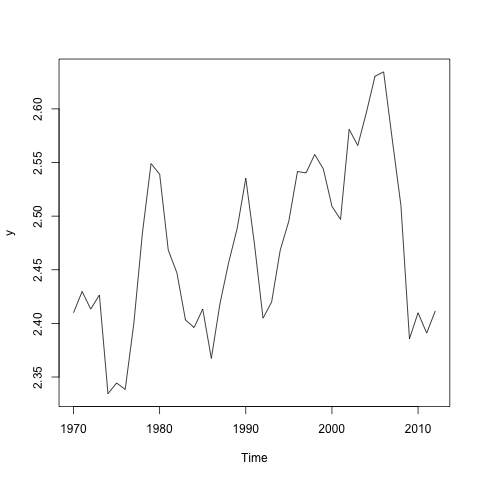

In [43]:
%R plot(y)

Run the bsts model. Given that the data is of low resolution, we cannot analyse seasonality. That is, we don't have monthly observations.

### Run the bsts model

In [9]:
%%R
ss <- AddLocalLinearTrend(list(), y)
fit_bsts <- bsts(y, state.specification = ss, niter = 1000, ping = 0, seed = 2017)

### Get a suggested number of burn-ins
burn <- SuggestBurn(0.1, fit_bsts)

### Predict
pred <- predict.bsts(fit_bsts, horizon = 3, burn = burn, quantiles = c(.025, .975))

### Actual versus predicted
d2 <- data.frame(
    # fitted values and predictions
    c(10^as.numeric(-colMeans(fit_bsts$one.step.prediction.errors[-(1:burn),])+y),  
    10^as.numeric(pred$mean)),
    # actual data and dates 
    as.numeric(ts_data),
    as.Date(time(ts_data)))
names(d2) <- c("Fitted", "Actual", "Date")

Visualize the fitted versus actual data

In [11]:
%R tail(d2)

,Fitted,Actual,Date
41,197.874193,257.0,14610.0
42,238.708284,246.0,14975.0
43,235.397245,258.0,15340.0
44,258.442150,262.0,15706.0
45,262.929669,291.0,16071.0
46,266.741803,321.0,16436.0


### Validation

Calculate the mean absolute percentage error from this model.

In [13]:
%%R
### MAPE (mean absolute percentage error)
MAPE_bsts <- filter(d2, lubridate::year(Date)>2012) %>% 
  summarise(MAPE=mean(abs(Actual-Fitted)/Actual))
MAPE_bsts

        MAPE
1 0.09302328


Visualize the fitted vs the actual including uncertainty intervals for the holdout/prediction periods.

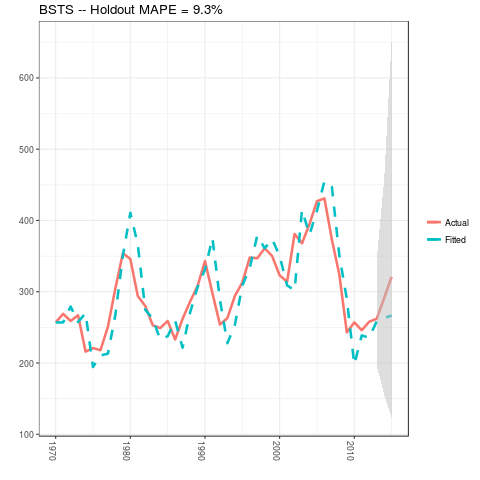

In [14]:
%%R
### 95% forecast credible interval
posterior.interval <- cbind.data.frame(
  10^as.numeric(pred$interval[1,]),
  10^as.numeric(pred$interval[2,]), 
  subset(d2, lubridate::year(Date)>2012)$Date)
names(posterior.interval) <- c("LL", "UL", "Date")

### Join intervals to the forecast
d3 <- left_join(d2, posterior.interval, by="Date")

### Plot actual versus predicted with credible intervals for the holdout period
ggplot(data=d3, aes(x=Date)) +
  geom_line(aes(y=Actual, colour = "Actual"), size=1.2) +
  geom_line(aes(y=Fitted, colour = "Fitted"), size=1.2, linetype=2) +
  theme_bw() + theme(legend.title = element_blank()) + ylab("") + xlab("") +
  geom_vline(xintercept=as.numeric(as.Date("1959-12-01")), linetype=2) + 
  geom_ribbon(aes(ymin=LL, ymax=UL), fill="grey", alpha=0.5) +
  ggtitle(paste0("BSTS -- Holdout MAPE = ", round(100*MAPE_bsts,2), "%")) +
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

### Visualise Components

Moreover, one of the big advantages of the Bayesian structural model is that we can visualize the underlying components. In this example, we’re using ggplot to plot the average of the MCMC draws for the trend components:

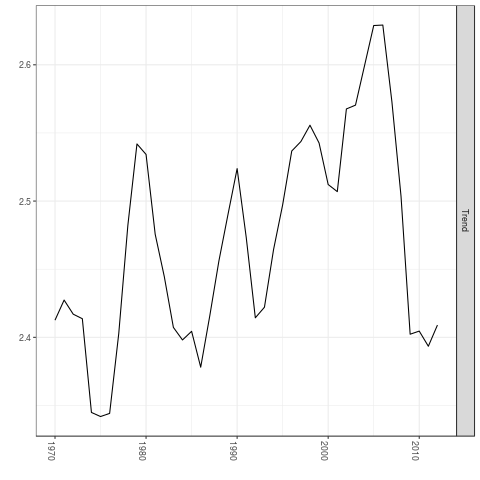

In [15]:
%%R
### Extract the components
components <- cbind.data.frame(
  colMeans(fit_bsts$state.contributions[-(1:burn),"trend",]),                               
  #colMeans(fit_bsts$state.contributions[-(1:burn),"seasonal.12.1",]),
  as.Date(time(Y)))  
#names(components) <- c("Trend", "Seasonality", "Date")
names(components) <- c("Trend", "Date")
components <- melt(components, id="Date")
names(components) <- c("Date", "Component", "Value")

### Plot
ggplot(data=components, aes(x=Date, y=Value)) + geom_line() + 
  theme_bw() + theme(legend.title = element_blank()) + ylab("") + xlab("") + 
  facet_grid(Component ~ ., scales="free") + guides(colour=FALSE) + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

## Autoregressive Integrated Moving Average (ARIMA)

### Fit the ARIMA model

In [16]:
%%R
fit_arima <- arima(log10(Y), 
               order=c(0, 1, 1), 
               seasonal=list(order=c(0,1,1), period=1))

### Actual versus predicted
d1 <- data.frame(c(10^as.numeric(fitted(fit_arima)), # fitted and predicted
                   10^as.numeric(predict(fit_arima, n.ahead = 3)$pred)),
                   as.numeric(ts_data), #actual values
                   as.Date(time(ts_data)))
names(d1) <- c("Fitted", "Actual", "Date")


Error in data.frame(c(10^as.numeric(fitted(fit_arima)), 10^as.numeric(predict(fit_arima,  : 
  arguments imply differing number of rows: 3, 46


Visualize the fitted versus actual data

In [ ]:
%R kable(tail(d1))

### Validation

Calculate the mean absolute percentage error from ARIMA.

In [ ]:
%%R
### MAPE (mean absolute percentage error)
MAPE_arima <- filter(d1, lubridate::year(Date)>2012) %>% 
  summarise(MAPE=mean(abs(Actual-Fitted)/Actual))
MAPE_arima

Visualize the fitted vs the actual. ARIMA does not produce uncertainty intervals for the holdout/prediction periods.

In [ ]:
%%R
### Plot actual versus predicted
ggplot(data=d1, aes(x=Date)) +
  geom_line(aes(y=Actual, colour = "Actual"), size=1.2) +
  geom_line(aes(y=Fitted, colour = "Fitted"), size=1.2, linetype=2) +
  theme_bw() + theme(legend.title = element_blank()) + 
  ylab("") + xlab("") +
  geom_vline(xintercept=as.numeric(as.Date("1959-12-01")), linetype=2) +
  ggtitle(paste0("ARIMA -- Holdout MAPE = ", round(100*MAPE_arima,2), "%")) + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0))